In [1]:
# Step 1: Install 7z tool
!apt-get install -y p7zip-full

# Step 2: Define archive path and extract to /content/
archive_path = '/content/drive/MyDrive/model/FLIR_ADAS_Thermal_SR.7z'

# Step 3: Extract to /content/
!7z x "{archive_path}" -o/content/ -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.

7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/model/                                       1 file, 1498640846 bytes (1430 MiB)

Extracting archive: /content/drive/MyDrive/model/FLIR_ADAS_Thermal_SR.7z
--
Path = /content/drive/MyDrive/model/FLIR_ADAS_Thermal_SR.7z
Type = 7z
Physical Size = 1498640846
Headers Size = 401813
Method = LZMA2:25
Solid = +
Blocks = 1

  0%      1% 129 - FLIR_ADAS_Thermal_SR/test/video- . rame-001552-wmiZctzdb4qqbCS2o.jpg

In [2]:

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import tensorflow as tf


In [3]:
# Paths for FLIR ADAS dataset
base_path = '/content/FLIR_ADAS_Thermal_SR'
train_folder = os.path.join(base_path, 'train')
test_folder = os.path.join(base_path, 'test')

def load_image_paths(folder_path):
    filenames = sorted(os.listdir(folder_path))
    return [os.path.join(folder_path, fname) for fname in filenames]

train_image_paths = load_image_paths(train_folder)
test_image_paths = load_image_paths(test_folder)

# Split train into train and validation sets
train_paths, val_paths = train_test_split(train_image_paths, test_size=0.2, random_state=42)

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [256, 256]) / 255.0
    hr = img
    lr = tf.image.resize(img, [128, 128])
    lr = tf.image.resize(lr, [256, 256])
    return lr, hr

train_ds = tf.data.Dataset.from_tensor_slices(train_paths)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(16).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(val_paths)
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(16).prefetch(tf.data.AUTOTUNE)

def preprocess_image_test(path):
    img = tf.io.read_file(path)
    img = tf.io.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, [256, 256]) / 255.0
    hr = img
    lr = tf.image.resize(img, [128, 128])
    lr = tf.image.resize(lr, [256, 256])
    return lr, hr

test_ds = tf.data.Dataset.from_tensor_slices(test_image_paths)
test_ds = test_ds.map(preprocess_image_test, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(16).prefetch(tf.data.AUTOTUNE)


In [4]:

# Build SRCNN model
input_img = Input(shape=(256, 256, 1))
x = Conv2D(64, (9, 9), activation='relu', padding='same')(input_img)
x = Conv2D(32, (1, 1), activation='relu', padding='same')(x)
x = Conv2D(1, (5, 5), activation='sigmoid', padding='same')(x)
model = Model(input_img, x)

model.compile(optimizer='adam', loss='mse')
model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 64)   │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 256, 256, 1)    │           801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,129 (31.75 KB)

 Trainable params: 8,129 (31.75 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# Model Checkpoint
checkpoint_path = 'best_srcnn_model.h5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)

# Train the SRCNN model
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=30,
                    callbacks=[checkpoint])


Epoch 1/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0102
Epoch 1: val_loss improved from inf to 0.00108, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 53s 65ms/step - loss: 0.0102 - val_loss: 0.0011
Epoch 2/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 9.8468e-04
Epoch 2: val_loss improved from 0.00108 to 0.00076, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 37s 52ms/step - loss: 9.8456e-04 - val_loss: 7.5551e-04
Epoch 3/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 7.4166e-04
Epoch 3: val_loss improved from 0.00076 to 0.00066, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 55ms/step - loss: 7.4164e-04 - val_loss: 6.6161e-04
Epoch 4/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.9483e-04
Epoch 4: val_loss did not improve from 0.00066
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 6.9480e-04 - val_loss: 6.8668e-04
Epoch 5/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 6.6228e-04
Epoch 5: val_loss improved from 0.00066 to 0.00060, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 53ms/step - loss: 6.6225e-04 - val_loss: 6.0480e-04
Epoch 6/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.3089e-04
Epoch 6: val_loss improved from 0.00060 to 0.00060, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 6.3090e-04 - val_loss: 6.0025e-04
Epoch 7/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.1938e-04
Epoch 7: val_loss improved from 0.00060 to 0.00060, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 6.1938e-04 - val_loss: 5.9649e-04
Epoch 8/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 6.0858e-04
Epoch 8: val_loss improved from 0.00060 to 0.00058, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 6.0861e-04 - val_loss: 5.8102e-04
Epoch 9/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.8471e-04
Epoch 9: val_loss improved from 0.00058 to 0.00058, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - loss: 5.8472e-04 - val_loss: 5.7515e-04
Epoch 10/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.8182e-04
Epoch 10: val_loss improved from 0.00058 to 0.00057, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - loss: 5.8184e-04 - val_loss: 5.7003e-04
Epoch 11/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.7795e-04
Epoch 11: val_loss did not improve from 0.00057
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 59ms/step - loss: 5.7797e-04 - val_loss: 5.7115e-04
Epoch 12/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.7212e-04
Epoch 12: val_loss improved from 0.00057 to 0.00057, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 5.7214e-04 - val_loss: 5.6984e-04
Epoch 13/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.7526e-04
Epoch 13: val_loss improved from 0.00057 to 0.00056, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 5.7527e-04 - val_loss: 5.6081e-04
Epoch 14/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.6471e-04
Epoch 14: val_loss did not improve from 0.00056
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 53ms/step - loss: 5.6472e-04 - val_loss: 5.6985e-04
Epoch 15/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.6474e-04
Epoch 15: val_loss improved from 0.00056 to 0.00056, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 46s 60ms/step - loss: 5.6476e-04 - val_loss: 5.5933e-04
Epoch 16/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.7414e-04
Epoch 16: val_loss did not improve from 0.00056
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - loss: 5.7414e-04 - val_loss: 5.6658e-04
Epoch 17/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.6313e-04
Epoch 17: val_loss improved from 0.00056 to 0.00055, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - loss: 5.6315e-04 - val_loss: 5.5419e-04
Epoch 18/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.5815e-04
Epoch 18: val_loss improved from 0.00055 to 0.00055, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 59ms/step - loss: 5.5816e-04 - val_loss: 5.5300e-04
Epoch 19/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.6269e-04
Epoch 19: val_loss did not improve from 0.00055
704/704 ━━━━━━━━━━━━━━━━━━━━ 77s 52ms/step - loss: 5.6271e-04 - val_loss: 5.9381e-04
Epoch 20/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.5569e-04
Epoch 20: val_loss improved from 0.00055 to 0.00055, saving model to best_srcnn_model.h5


704/704 ━━━━━━━━━━━━━━━━━━━━ 45s 58ms/step - loss: 5.5569e-04 - val_loss: 5.4962e-04
Epoch 21/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.6224e-04
Epoch 21: val_loss did not improve from 0.00055
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 59ms/step - loss: 5.6229e-04 - val_loss: 6.6131e-04
Epoch 22/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 5.9667e-04
Epoch 22: val_loss did not improve from 0.00055
704/704 ━━━━━━━━━━━━━━━━━━━━ 78s 54ms/step - loss: 5.9666e-04 - val_loss: 5.9751e-04
Epoch 23/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.8717e-04
Epoch 23: val_loss did not improve from 0.00055
704/704 ━━━━━━━━━━━━━━━━━━━━ 41s 54ms/step - loss: 5.8716e-04 - val_loss: 5.7066e-04
Epoch 24/30
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.7162e-04
Epoch 24: val_loss did not improve from 0.00055
704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 5.7162e-04 - val_loss: 5.6182e-04
Epoch 25/30
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 5.6213e-04
Epoch 25: val_loss

704/704 ━━━━━━━━━━━━━━━━━━━━ 38s 54ms/step - loss: 5.5053e-04 - val_loss: 5.4637e-04


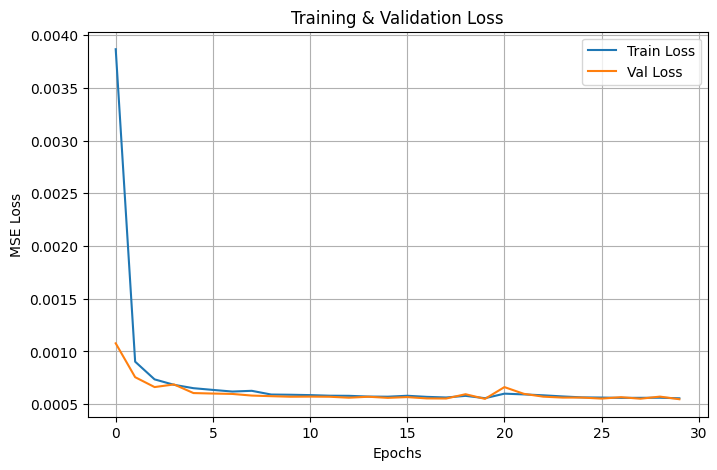

In [6]:
# Plot Training and Validation Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━

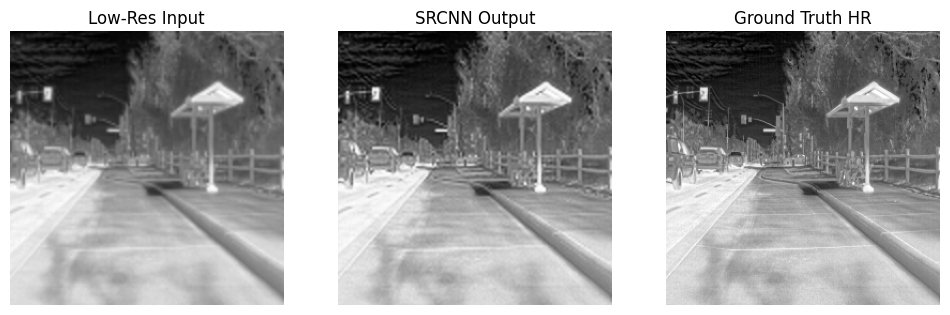

Test Image 1: PSNR=30.56, SSIM=0.8746


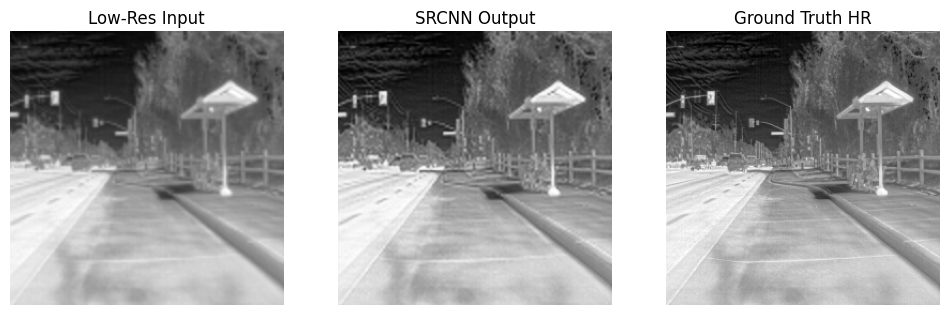

Test Image 2: PSNR=32.05, SSIM=0.8969


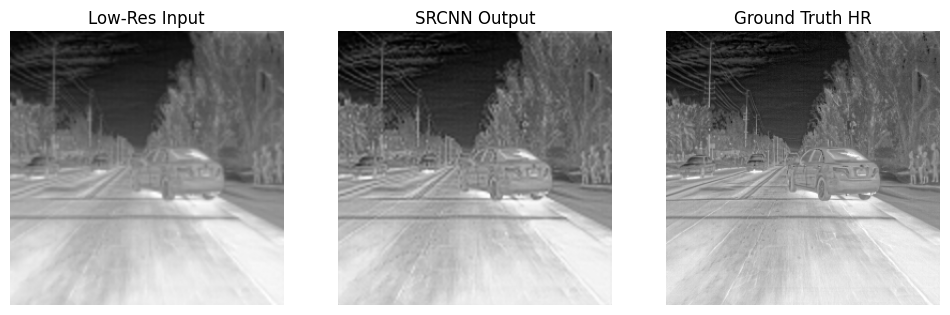

Test Image 3: PSNR=32.59, SSIM=0.8876


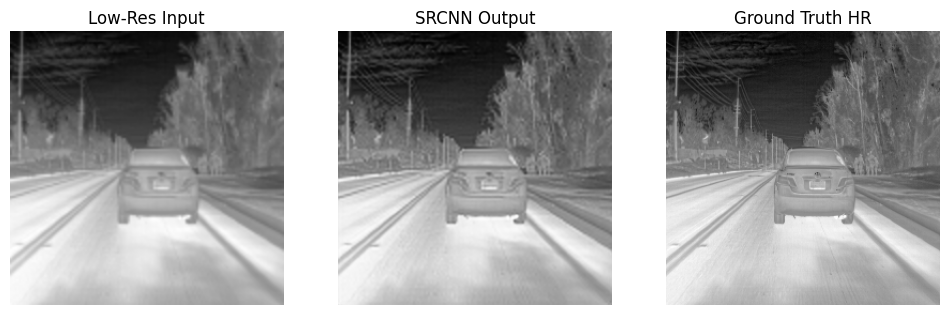

Test Image 4: PSNR=33.71, SSIM=0.9115


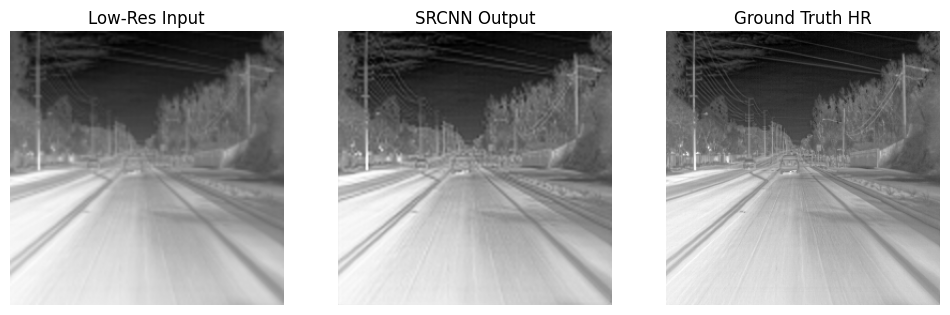

Test Image 5: PSNR=34.33, SSIM=0.9195


In [15]:
import pandas as pd
# Load the best model
best_model = tf.keras.models.load_model('best_srcnn_model.h5', compile=False)

# Evaluate PSNR and SSIM on entire Test Set
def evaluate_psnr_ssim(original, reconstructed):
    original = original.numpy() if tf.is_tensor(original) else original
    reconstructed = reconstructed.numpy() if tf.is_tensor(reconstructed) else reconstructed
    p = psnr(np.squeeze(original), np.squeeze(reconstructed), data_range=1.0)
    s = ssim(np.squeeze(original), np.squeeze(reconstructed), data_range=1.0)
    return p, s

psnr_list, ssim_list = [], []
for lr_imgs, hr_imgs in test_ds:
    preds = best_model.predict(lr_imgs)
    for i in range(len(lr_imgs)):
        p, s = evaluate_psnr_ssim(hr_imgs[i], preds[i])
        psnr_list.append(p)
        ssim_list.append(s)

avg_psnr = np.mean(psnr_list)
avg_ssim = np.mean(ssim_list)

print(f"\nEvaluation on Whole Test Set:")
print(f"Average PSNR: {avg_psnr:.2f}")
print(f"Average SSIM: {avg_ssim:.4f}")

# Save PSNR and SSIM to CSV
results_df = pd.DataFrame({
    'Image_Index': np.arange(len(psnr_list)),
    'PSNR': psnr_list,
    'SSIM': ssim_list
})
results_df.to_csv('psnr_ssim_results.csv', index=False)
print("PSNR and SSIM results saved to 'psnr_ssim_results.csv'.")

# Visualize and Evaluate some Test Predictions
for lr_imgs, hr_imgs in test_ds.take(1):
    preds = best_model.predict(lr_imgs)
    for i in range(min(5, len(lr_imgs))):
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(lr_imgs[i].numpy().squeeze(), cmap='gray')
        plt.title("Low-Res Input")
        plt.axis('off')
        plt.subplot(1,3,2)
        plt.imshow(np.squeeze(preds[i]), cmap='gray')
        plt.title("SRCNN Output")
        plt.axis('off')
        plt.subplot(1,3,3)
        plt.imshow(hr_imgs[i].numpy().squeeze(), cmap='gray')
        plt.title("Ground Truth HR")
        plt.axis('off')
        plt.show()
        print(f"Test Image {i+1}: PSNR={psnr_list[i]:.2f}, SSIM={ssim_list[i]:.4f}")


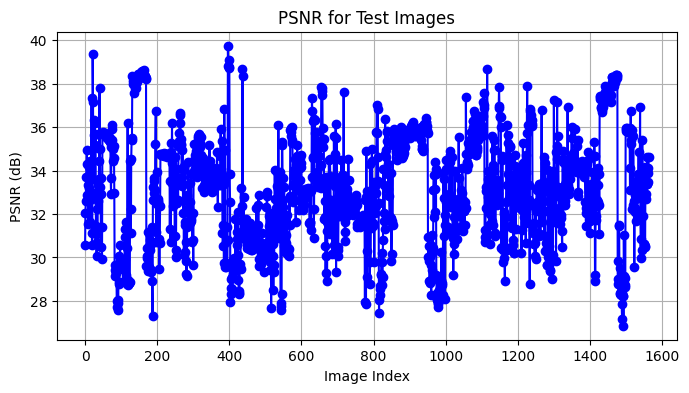

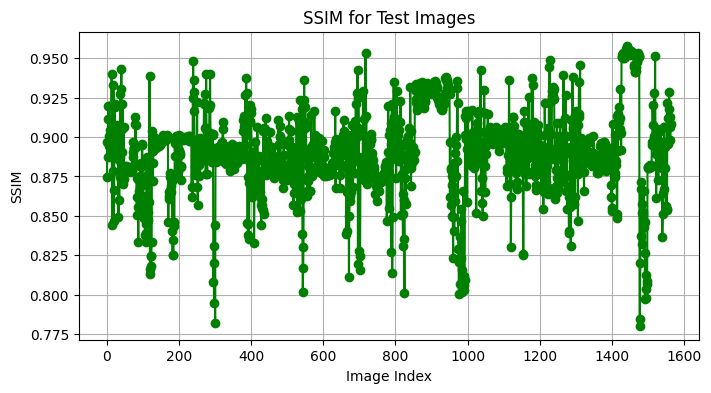

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV
results_df = pd.read_csv('/content/psnr_ssim_results.csv')

# Plot PSNR
plt.figure(figsize=(8,4))
plt.plot(results_df['Image_Index'], results_df['PSNR'], marker='o', linestyle='-', color='blue')
plt.title('PSNR for Test Images')
plt.xlabel('Image Index')
plt.ylabel('PSNR (dB)')
plt.grid(True)
plt.show()

# Plot SSIM
plt.figure(figsize=(8,4))
plt.plot(results_df['Image_Index'], results_df['SSIM'], marker='o', linestyle='-', color='green')
plt.title('SSIM for Test Images')
plt.xlabel('Image Index')
plt.ylabel('SSIM')
plt.grid(True)
plt.show()


In [17]:
import os
output_path = '/content/SRCNN_Output/'

os.makedirs(output_path, exist_ok=True)

for idx, (lr_imgs, _) in enumerate(test_ds):
    preds = best_model.predict(lr_imgs)
    for i in range(len(preds)):
        out_img = np.squeeze(preds[i]) * 255.0  # scale back to [0,255]
        out_img = out_img.astype(np.uint8)
        cv2.imwrite(f"{output_path}/img_{idx*len(preds)+i}.jpg", out_img)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━

In [18]:
import shutil

shutil.make_archive('/content/SRCNN_Output', 'zip', '/content/SRCNN_Output')


'/content/SRCNN_Output.zip'

In [19]:
from google.colab import files
files.download('/content/SRCNN_Output.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [1]:
from ultralytics import YOLO

# Load your trained YOLOv8 model (or pretrained model)
model = YOLO('yolov8n.pt')  # Replace with your custom model if available

# Run inference on saved SRCNN outputs
results = model.predict(source='/content/SRCNN_Output/', save=True, conf=0.25)  # conf=0.25 is confidence threshold

# Print detections for each image
for i, result in enumerate(results):
    print(f"\nImage {i}:")
    if result.boxes is not None:
        boxes = result.boxes.xyxy.cpu().numpy()   # x1, y1, x2, y2
        scores = result.boxes.conf.cpu().numpy()  # confidence
        classes = result.boxes.cls.cpu().numpy()  # class indices
        for box, score, cls in zip(boxes, scores, classes):
            print(f" Class: {int(cls)}, Confidence: {score:.2f}, Box: {box}")
    else:
        print(" No detections.")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 70.6MB/s]


Streaming output truncated to the last 5000 lines.
image 1450/1552 /content/SRCNN_Output/img_906.jpg: 640x640 4 persons, 1 car, 9.3ms
image 1451/1552 /content/SRCNN_Output/img_907.jpg: 640x640 3 persons, 1 car, 1 truck, 7.2ms
image 1452/1552 /content/SRCNN_Output/img_908.jpg: 640x640 3 persons, 1 car, 5.9ms
image 1453/1552 /content/SRCNN_Output/img_909.jpg: 640x640 1 person, 1 car, 6.0ms
image 1454/1552 /content/SRCNN_Output/img_91.jpg: 640x640 1 car, 10.1ms
image 1455/1552 /content/SRCNN_Output/img_910.jpg: 640x640 2 persons, 2 cars, 6.2ms
image 1456/1552 /content/SRCNN_Output/img_911.jpg: 640x640 1 car, 7.6ms
image 1457/1552 /content/SRCNN_Output/img_912.jpg: 640x640 1 car, 5.9ms
image 1458/1552 /content/SRCNN_Output/img_913.jpg: 640x640 1 car, 1 truck, 6.0ms
image 1459/1552 /content/SRCNN_Output/img_914.jpg: 640x640 2 cars, 5.9ms
image 1460/1552 /content/SRCNN_Output/img_915.jpg: 640x640 1 car, 6.0ms
image 1461/1552 /content/SRCNN_Output/img_916.jpg: 640x640 1 car, 8.2ms
image 1462/

In [2]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')  # or your custom-trained YOLOv8 model

results = model.predict(
    source='/content/SRCNN_Output/',
    save=True,
    project='/content/Detection_Results/',  # Custom output folder
    name='Thermal_SR_Detect',               # Subfolder name
    conf=0.25                               # Confidence threshold
)

print("All detection images saved to '/content/Detection_Results/Thermal_SR_Detect/'.")



WARNING ⚠️ 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1552 /content/SRCNN_Output/img_0.jpg: 640x640 (no detections), 27.4ms
image 2/1552 /content/SRCNN_Output/img_1.jpg: 640x640 (no detections), 11.2ms
image 3/1552 /content/SRCNN_Output/img_10.jpg: 640x640 (no detections), 11.8ms
image 4/1552 /content/SRCNN_Output/img_100.jpg: 640x640 7 persons, 24.0ms
image 5/1552 /content/SRCNN_Output/img_1000.jpg: 640x640 1 person, 3 cars, 33.7ms
image 6/1552 /content/SRCNN_Output/img_1001.jpg: 640x640 (no dete

In [4]:
import shutil

shutil.make_archive('/content/runs', 'zip', '/content/runs')

from google.colab import files
files.download('/content/runs')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd

all_detections = []

for i, result in enumerate(results):
    if result.boxes is not None:
        boxes = result.boxes.xyxy.cpu().numpy()  # Bounding boxes [x1, y1, x2, y2]
        scores = result.boxes.conf.cpu().numpy()  # Confidence scores
        classes = result.boxes.cls.cpu().numpy()  # Class IDs
        for box, score, cls in zip(boxes, scores, classes):
            all_detections.append({
                'Image_Index': i,
                'Class_ID': int(cls),
                'Confidence': float(score),
                'Box_X1': float(box[0]),
                'Box_Y1': float(box[1]),
                'Box_X2': float(box[2]),
                'Box_Y2': float(box[3])
            })

# Convert to DataFrame and save as CSV
df_detections = pd.DataFrame(all_detections)
df_detections.to_csv('/content/Detection_Results/detection_results.csv', index=False)

print("Detection results saved to '/content/Detection_Results/detection_results.csv'.")


Detection results saved to '/content/Detection_Results/detection_results.csv'.
